# Don't use the test error for predictor selection

Many articles in machine learning follow this pattern: 
* a new algorithm is proposed
* it then is tested against a number of other algorithms from the literature on some problem
* the new algorithm achieves the lowest test error and is thus deemed superior to the other algorithms
  
If done well, there's not much wrong with this. However, if many algorithms are compared and then the one with the lowest test error is chosen, the test error will no longer accurately reflect performance on new data. Effectively, the test set has leached into the training of the algorithm. Let me explain.

As a first step, we set up a binary classification task, where the classes are uniformly random. Thus: **no classifier** can achieve a true risk **lower than 50%.** (Bayes error is 50%.) 

As classifiers we will use here random forests consisting of three trees each. Such a random forest is clearly rubbish. That, however, is not the point -- the task itself is rubbish, too, as the classes are completely unconnected to the data. The point here is that if a instantiate 100 random forests then we will get 100 different predictors. 

We also draw training set that we will keep fixed.

In [1]:
import numpy as np
import sklearn.ensemble
import sklearn.metrics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
def generate_Xy(num_samples=1000,num_features=100):
    X=np.random.random(size=(num_samples,num_features))
    y=np.random.randint(low=0,high=2,size=num_samples)
    return X,y

X_train,y_train=generate_Xy()

## Estimate the variation in the test error

One complication here is that the test error is just an estimation of the true risk and thus will vary. As a first step we need to figure out how much the test error varies in our setting. For this we train many classifiers and draw many test sets, and then determine their test error. From this empirical distribution, we then choose the 5%-percentile.

In [3]:
num=1000
test_sets=[generate_Xy() for _ in range(num)]
trees=[sklearn.ensemble.RandomForestClassifier(n_estimators=3).fit(X_train,y_train) for _ in range(num)]
many_test_errors=[1-sklearn.metrics.accuracy_score(tree.predict(X),y) for (X,y),tree in zip(test_sets,trees)]

(0.47495, 0.525)

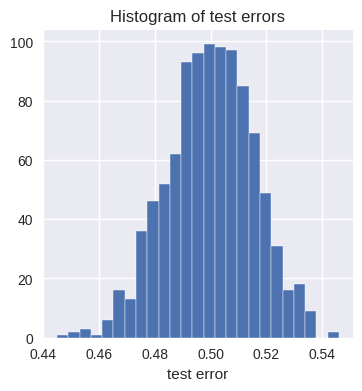

In [4]:
fig,ax=plt.subplots(figsize=(4,4))
ax.hist(many_test_errors,bins=25,edgecolor='white')
ax.set_title("Histogram of test errors")
ax.set_xlabel("test error")
np.percentile(many_test_errors,5),np.percentile(many_test_errors,95)

Thus, we can expect that with about 95% probability the test error of some classifier is at least 47%. That is, if we calculate a test error for a classifier, it will deviate from the true risk (which is 50% or larger) but it is very likely that it will not be lower than 47%. 

Note: We do not know the true risks of the classifiers -- but what we do know is that it cannot be smaller than 50%. 

## Using the test set for algorithm selection

Now that we know that the test error should be at least 47%, let's do the actual experiment.

* We train 1000 classifiers.
* We evaluate each on the same test set.
* We then choose the *best* classifier, ie, the one with lowest test error.
Does the test error of the chosen classifier give a good estimate of its true risk? (Spoiler: No.)

First: instantiate 1000 random forests, and train them on the training set. 

In [5]:
trees=[sklearn.ensemble.RandomForestClassifier(n_estimators=3).fit(X_train,y_train) for _ in range(1000)]

Next, draw a test set and compute the test errors. 

In [6]:
X_test,y_test=np.random.random(size=(1000,100)),np.random.randint(low=0,high=2,size=1000)
test_errors=[1-sklearn.metrics.accuracy_score(tree.predict(X_test),y_test) for tree in trees]

What is the smallest test error?

In [7]:
min(test_errors),max(test_errors)

(0.45199999999999996, 0.55)

Would we now expect the classifier with smallest test error to perform this well on new data? No, even considering the statistical spread of the test error. That is, above we had seen that, with large probability, the test error is too optimistic by at most 3%. Here, however, the ``best'' classifier has a test error that is lower than the true risk by at least 4.5%. The test error is much too optimistic about the performance of the classifier. 

To recap:
* Don't use the test error to select a ``best'' algorithm among many algorithms and expect the test error to give you a good estimate of the true risk.
* Instead, use a validation set to select the best algorithm and then estimate the true risk of the chosen algorithm via the test error.
* If you just compare a few algorithms (three, say) on the test set, then the test error will likely still give you a good estimate of the true risk.